# set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install facenet_pytorch
!pip install lpips
!pip install pytorch-msssim
!pip install wandb

In [3]:
import os

In [ ]:
!git clone https://github.com/danielroich/Face-Identity-Disentanglement-via-StyleGan2.git 'project'
CODE_DIR = 'project'
os.chdir(f'./{CODE_DIR}')

In [5]:
BASE_PATH = '/content/drive/MyDrive/CNN-project-weights/'

In [6]:
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

In [7]:
from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

# network

In [ ]:
id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)
attr_encoder = Inception()
discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE, 512, 8)

In [ ]:
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

In [10]:
# load our checkpoints

attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616260880.7093115_0.pt')
mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616260879.542158_0.pt')

In [11]:
id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
generator = generator.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

In [12]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.eval()
generator = generator.eval()
mlp = mlp.eval()
landmark_encoder = landmark_encoder.eval()

# get images

In [13]:
w_image_dataset = Image_W_Dataset(W_DATA_DIR, IMAGE_DATA_DIR)
data_loader = DataLoader(dataset=w_image_dataset, batch_size=config['batchSize'], shuffle=False)

In [14]:
data = next(iter(data_loader))

In [15]:
ws, images = data

In [16]:
import matplotlib.pyplot as plt

In [17]:
plot_images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)

In [18]:
# choose idx 
id_idx = 5

In [19]:
attr_idx = (config['batchSize']-1) if id_idx==0 else (id_idx - 1)

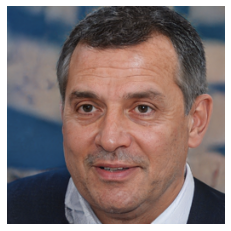

In [20]:
# identity

plt.axis('off')
plt.imshow(plot_images[id_idx])
plt.show()

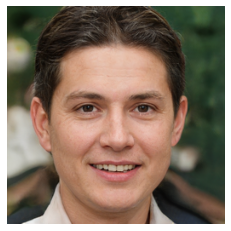

In [21]:
# attribute

plt.axis('off')
plt.imshow(plot_images[attr_idx])
plt.show()

# have fun!

In [22]:
test_ws = ws.to(Global_Config.device)
test_id_images = images.to(Global_Config.device)
test_attr_images_cycled = cycle_images_to_create_diff_order(test_id_images)

In [23]:
def get_concat_vec(id_images, attr_images, id_encoder, attr_encoder):
    with torch.no_grad():
        id_vec = torch.squeeze(id_encoder.extract_feats((id_images * 2) - 1))
        attr_vec = torch.squeeze(attr_encoder(attr_images))
        test_vec = torch.cat((id_vec, attr_vec), dim=1)
        return test_vec

In [ ]:
concat_vec_cycled = get_concat_vec(test_id_images, test_attr_images_cycled, id_encoder, attr_encoder)

In [25]:
with torch.no_grad():
  mapped_concat_vec_cycled = mlp(concat_vec_cycled)

In [26]:
with torch.no_grad():
  cycled_generated_image = get_w_image(mapped_concat_vec_cycled[id_idx], generator)

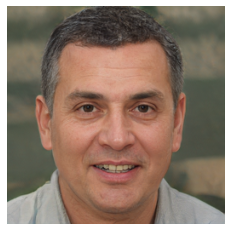

In [27]:
# Result!

plt.axis('off')
plt.imshow(cycled_generated_image)
plt.show()